In [8]:
## RECSYS CHALLENGE 2020 ##
# Evaluation or scoring?
eval = True

In [9]:
# Loading from CSV files...
from RecLib.DataLoad import *
UCM_age, ICM_subclass, ICM_asset, ICM_price, UCM_region, target_users, URM = dataLoad()

In [10]:
import scipy.sparse as sps
URM = URM.tocsr()

In [11]:
# Split dataset (train % of .9999 gives similar performance on test set and competition set)
from Notebooks_utils.data_splitter import train_test_holdout
URM_train, URM_test = train_test_holdout(URM, train_perc = 0.8)


if not eval:
    URM_train = URM
else:
    from Base.Evaluation.Evaluator import EvaluatorHoldout
    from RecLib.Evaluate import *
    evaluator_validation = EvaluatorHoldout(URM_test, cutoff_list=[10])

In [12]:
# Load Item & User Content matrix
ICM, UCM = contentMatrixLoad(URM_train, ICM_subclass, ICM_price, ICM_asset, UCM_age, UCM_region)

In [43]:
profile_length = np.ediff1d(URM_train.indptr)
item_pop = np.ediff1d(URM_train.tocsc().indptr)

ICM_mod = sps.hstack((ICM,item_pop[:,None]))
UCM_mod = sps.hstack((UCM, profile_length[:, None]))

In [6]:
if True:
    from SLIM_ElasticNet.SLIMElasticNetRecommender import SLIMElasticNetRecommender
    SLIMElasticNet = SLIMElasticNetRecommender(URM_train)
    MAP_LIST = []
    tklist = [30, 50, 60]
    penalties = [1]
    alphas = [0.2, 0.4, 0.7, 1]
    tol = [1e-3, 1e-4, 1e-5]
    max_iter = [100, 1000]
    positives = [False, True]
    warm_start = [True, False]
    for tk in tklist:
        for penalty in penalties:
            for alpha in alphas:
                for positivity in positives:
                    for ws in warm_start:
                        SLIMElasticNet.fit(l1_ratio=penalty, alpha = alpha, positive_only=positivity, topK = tk, warm_start = ws)
                        if eval:
                            dict_scores = (evaluator_validation.evaluateRecommender(SLIMElasticNet))[0][10]
                            MAP_LIST.append(('topK, l1_ratio, alphas :' + str(tk) + ' ' + str(penalty) + ' ' + str(alpha), dict_scores['MAP']))
    if eval:
        sortMap(MAP_LIST)

KeyboardInterrupt: 

In [ ]:
# SLIM BPR Recommender
if True:
    from SLIM_BPR.Cython.SLIM_BPR_Cython import SLIM_BPR_Cython 
    slim_rec = SLIM_BPR_Cython(URM_train, recompile_cython=False, verbose = False)
    MAP_LIST = []
    epochsList = [300]
    batchSize = [50]
    tklist = [10]
    lrs = [1e-3]

    for epochsN in epochsList:
        for bs in batchSize:
            for tk in tklist:
                for lr in lrs:
                    do_not_display_hystory = slim_rec.fit(epochs=epochsN, batch_size=bs, sgd_mode='adagrad', learning_rate=lr, topK = tk)
                    if eval:
                        dict_scores = (evaluator_validation.evaluateRecommender(slim_rec))[0][10]
                        MAP_LIST.append(('epoch, batch, topK, lr :' + str(epochsN) + ' ' + str(bs)+ ' ' + str(tk) + ' ' + str(lr), dict_scores['MAP']))
    if eval:
        sortMap(MAP_LIST)

In [21]:
# ItemKNN Content Based Filtering
if True:
    from KNN.ItemKNNCBFRecommender import ItemKNNCBFRecommender 
    itemKNNCBF = ItemKNNCBFRecommender(URM_train, ICM)
    MAP_LIST = []
    tklist = [3]
    shrinklist = [10]

    for tk in tklist:
        for sr in shrinklist:
            itemKNNCBF.fit(shrink=sr, topK = tk, similarity = 'cosine')
            if eval:
                dict_scores = (evaluator_validation.evaluateRecommender(itemKNNCBF))[0][10]
                MAP_LIST.append(('topK, shrink :' + str(tk) + ' ' + str(sr), dict_scores['MAP']))
    if eval:
        sortMap(MAP_LIST)

Similarity column 18495 ( 100 % ), 9736.11 column/sec, elapsed time 0.03 min
EvaluatorHoldout: Processed 20356 ( 100.00% ) in 10.14 sec. Users per second: 2007
('topK, shrink :3 10', 0.013461550763875911)


In [ ]:
#%%
if True:
    from MatrixFactorization.PureSVDRecommender import PureSVDRecommender 
    pureSVD = PureSVDRecommender(URM_train)
    MAP_LIST = []
    nfactorlist = [400]

    for n in nfactorlist:
        pureSVD.fit(num_factors=n, random_seed = None)
        if eval:
            dict_scores = (evaluator_validation.evaluateRecommender(pureSVD))[0][10]
            MAP_LIST.append(('num factors :' + str(n) , dict_scores['MAP']))
    if eval:
        print(MAP_LIST)  

In [ ]:
# UserKNN Content Based Filtering
if True:
    from KNN.UserKNNCBFRecommender import UserKNNCBFRecommender 
    userKNNCBF = UserKNNCBFRecommender(URM_train, UCM)
    MAP_LIST = []
    tklist = [2500]
    shrinklist = [10]

    for tk in tklist:
        for sr in shrinklist:
            userKNNCBF.fit(shrink=sr, topK = tk, similarity = 'cosine')
            if eval:
                dict_scores = (evaluator_validation.evaluateRecommender(userKNNCBF))[0][10]
                MAP_LIST.append(('topK, shrink :' + str(tk) + ' ' + str(sr), dict_scores['MAP']))
    if eval:
        print(MAP_LIST)
        

In [ ]:
# LightFM Recommender
if False:
    from RecLib.LFMRec import LFM 
    lfm_rec = LFM(URM_train)
    MAP_LIST = []
    epochsList = [20]
    batchSize = [50]
    tklist = [10]
    lrs = [0.05]
    losses=['bpr', 'warp']

    for epochsN in epochsList:
        for loss in losses:
            for tk in tklist:
                for lr in lrs:
                    do_not_display_hystory = lfm_rec.fit(epochs=epochsN, no_components=10,
            k=5,
            n=10,
            learning_schedule="adagrad",
            loss=loss,
            learning_rate=lr,
            rho=0.95,
            epsilon=1e-6,
            item_alpha=0.0,
            user_alpha=0.0,
            max_sampled=10,
            random_state=None, num_threads=1,
            verbose=False)
                    if eval:
                        dict_scores = (evaluator_validation.evaluateRecommender(lfm_rec))[0][10]
                        MAP_LIST.append(('epoch, loss, lr :' + str(epochsN) + ' ' + loss + ' '  + str(lr), dict_scores['MAP']))
    if eval:
        sortMap(MAP_LIST)

In [ ]:
# UserKNN Collaborative Filtering
if False:
    from KNN.UserKNNCFRecommender import UserKNNCFRecommender 
    userKNNCF = UserKNNCFRecommender(URM_train)
    MAP_LIST = []
    tklist = [600]
    shrinklist = [5]

    for tk in tklist:
        for sr in shrinklist:
            userKNNCF.fit(shrink=sr, topK = tk, similarity = 'cosine')
            if eval:
                dict_scores = (evaluator_validation.evaluateRecommender(userKNNCF))[0][10]
                MAP_LIST.append(('topK, shrink :' + str(tk) + ' ' + str(sr), dict_scores['MAP']))
    if eval:
        sortMap(MAP_LIST)    

In [13]:
# ItemKNN Collaborative Filtering
if True:
    from KNN.ItemKNNCFRecommender import ItemKNNCFRecommender
    itemKNN = ItemKNNCFRecommender(URM_train)
    itemKNN.fit(shrink=50, topK=5)

    if eval:
        evaluator_validation = EvaluatorHoldout(URM_test, cutoff_list=[10])
        results, _ = evaluator_validation.evaluateRecommender(itemKNN)
        print('MAP: ' + str(results[10]["MAP"]))

Similarity column 18495 ( 100 % ), 6437.66 column/sec, elapsed time 0.05 min
EvaluatorHoldout: Processed 20356 ( 100.00% ) in 10.92 sec. Users per second: 1865
MAP: 0.04532085813035659


In [ ]:
if False:
    import xgboost as xgb
    dtest = xgb.DMatrix(X_test, label=y_test)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=3)
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_val, label=y_val)
    
    params = {
    'max_depth': 3,  # the maximum depth of each tree
    'eta': 0.3,  # step for each iteration
    'silent': 1, # keep it quiet
    'objective': 'multi:softprob',  # error evaluation for multiclass training
    'num_class': 3, # the number of classes 
    'eval_metric': 'merror'} # evaluation metric 

    num_round = 20  # the number of training iterations (number of trees)
    model = xgb.train(params,
                  dtrain,
                  num_round,
                  verbose_eval=2,
                  evals=[(dtrain, 'train'), (dval, 'validation')],
                  early_stopping_rounds=20)
    from sklearn.metrics import precision_score

    preds = model.predict(dtest)
    best_preds = np.asarray([np.argmax(line) for line in preds])
    print("Precision: {:.4f} %".format(precision_score(y_test, best_preds, average='macro')))
    

In [ ]:
# Graph Based
if True:
    from GraphBased.P3alphaRecommender import P3alphaRecommender
    p3alpha_rec = P3alphaRecommender(URM_train)
    MAP_LIST = []
    similList = [True]
    tklist = [30]
    alphaList = [0.4]

    for simil in similList:
        for tk in tklist:
            for alpha in alphaList:
                do_not_display_hystory = p3alpha_rec.fit(topK=tk, alpha=alpha, normalize_similarity=simil)
                if eval:
                    dict_scores = (evaluator_validation.evaluateRecommender(p3alpha_rec))[0][10]
                    MAP_LIST.append(('Normalize, topK, alpha :' + str(simil)+ ' ' + str(tk) + ' ' + str(alpha), dict_scores['MAP']))
    if eval:
        sortMap(MAP_LIST)
    

In [18]:
if True:
    from GraphBased.RP3betaRecommender import RP3betaRecommender
    p3beta_rec = RP3betaRecommender(URM_train)
    MAP_LIST = []
    betaList = [0.1]
    similList = [True]
    tklist = [50]
    alphaList = [0.4]

    for beta in betaList:
        for simil in similList:
            for tk in tklist:
                for alpha in alphaList:
                    do_not_display_hystory = p3beta_rec.fit(topK=tk, alpha=alpha, beta=beta, normalize_similarity=simil)
                    if eval:
                        dict_scores = (evaluator_validation.evaluateRecommender(p3beta_rec))[0][10]
                        MAP_LIST.append(('Normalize, topK, alpha, beta :' + str(simil)+ ' ' + str(tk) + ' ' + str(alpha) + ' ' + str(beta), dict_scores['MAP']))

    if eval:
        sortMap(MAP_LIST)

EvaluatorHoldout: Processed 20356 ( 100.00% ) in 11.94 sec. Users per second: 1705
('Normalize, topK, alpha, beta :True 50 0.4 0.1', 0.04735504984691491)


In [49]:
if True:
    W_sparse_CF = itemKNN.W_sparse    
    from FeatureWeighting.CFW_D_Similarity_Linalg import CFW_D_Similarity_Linalg
    CFW_weithing = CFW_D_Similarity_Linalg(URM_train, ICM, W_sparse_CF)
    MAP_LIST = []
    quotas = [0.1]
    similList = [False]
    tklist = [700]

    for quota in quotas:
        for normalization in similList:
            for tk in tklist:  
                    CFW_weithing.fit(topK = tk, add_zeros_quota = quota, normalize_similarity = normalization)
                    if eval:
                        dict_scores = (evaluator_validation.evaluateRecommender(CFW_weithing))[0][10]
                        MAP_LIST.append(('Normalize, topK, quota :' + str(normalization)+ ' ' + str(tk) + ' ' + str(quota), dict_scores['MAP']))

    if eval:
        sortMap(MAP_LIST)

CFW_D_Similarity_Linalg: Generating train data
Similarity column 18495 ( 100 % ), 4146.23 column/sec, elapsed time 0.07 min
CFW_D_Similarity_Linalg: Collaborative S density: 2.15E-04, nonzero cells 73419
CFW_D_Similarity_Linalg: Content S density: 2.70E-04, nonzero cells 92445
CFW_D_Similarity_Linalg: Content S structure has 410 out of 92445 ( 0.44%) nonzero collaborative cells
CFW_D_Similarity_Linalg: Nonzero collaborative cell sum is: 1.35E+01, average is: 3.30E-02, average over all collaborative data is 2.81E-02
Similarity column 18495 ( 100 % ), 3925.21 column/sec, elapsed time 0.08 min
EvaluatorHoldout: Processed 20356 ( 100.00% ) in 10.54 sec. Users per second: 1932
CFW_D_Similarity_Linalg: Generating train data
Similarity column 18495 ( 100 % ), 4234.26 column/sec, elapsed time 0.07 min
CFW_D_Similarity_Linalg: Collaborative S density: 2.15E-04, nonzero cells 73419
CFW_D_Similarity_Linalg: Content S density: 1.62E-03, nonzero cells 552438
CFW_D_Similarity_Linalg: Content S struc

EvaluatorHoldout: Processed 20356 ( 100.00% ) in 20.96 sec. Users per second: 971
CFW_D_Similarity_Linalg: Generating train data
Similarity column 18495 ( 100 % ), 3868.45 column/sec, elapsed time 0.08 min
CFW_D_Similarity_Linalg: Collaborative S density: 2.15E-04, nonzero cells 73419
CFW_D_Similarity_Linalg: Content S density: 2.70E-04, nonzero cells 92445
CFW_D_Similarity_Linalg: Content S structure has 410 out of 92445 ( 0.44%) nonzero collaborative cells
CFW_D_Similarity_Linalg: Nonzero collaborative cell sum is: 1.35E+01, average is: 3.30E-02, average over all collaborative data is 2.81E-02
Similarity column 18495 ( 100 % ), 3797.38 column/sec, elapsed time 0.08 min
EvaluatorHoldout: Processed 20356 ( 100.00% ) in 11.13 sec. Users per second: 1829
CFW_D_Similarity_Linalg: Generating train data
Similarity column 18495 ( 100 % ), 4194.58 column/sec, elapsed time 0.07 min
CFW_D_Similarity_Linalg: Collaborative S density: 2.15E-04, nonzero cells 73419
CFW_D_Similarity_Linalg: Content 

EvaluatorHoldout: Processed 20356 ( 100.00% ) in 20.14 sec. Users per second: 1011
CFW_D_Similarity_Linalg: Generating train data
Similarity column 18495 ( 100 % ), 4019.66 column/sec, elapsed time 0.08 min
CFW_D_Similarity_Linalg: Collaborative S density: 2.15E-04, nonzero cells 73419
CFW_D_Similarity_Linalg: Content S density: 2.70E-04, nonzero cells 92445
CFW_D_Similarity_Linalg: Content S structure has 410 out of 92445 ( 0.44%) nonzero collaborative cells
CFW_D_Similarity_Linalg: Nonzero collaborative cell sum is: 1.35E+01, average is: 3.30E-02, average over all collaborative data is 2.81E-02
Similarity column 18495 ( 100 % ), 3445.00 column/sec, elapsed time 0.09 min
EvaluatorHoldout: Processed 20356 ( 100.00% ) in 11.47 sec. Users per second: 1774
CFW_D_Similarity_Linalg: Generating train data
Similarity column 18495 ( 100 % ), 3873.32 column/sec, elapsed time 0.08 min
CFW_D_Similarity_Linalg: Collaborative S density: 2.15E-04, nonzero cells 73419
CFW_D_Similarity_Linalg: Content

EvaluatorHoldout: Processed 20356 ( 100.00% ) in 21.86 sec. Users per second: 931
CFW_D_Similarity_Linalg: Generating train data
Similarity column 18495 ( 100 % ), 3510.72 column/sec, elapsed time 0.09 min
CFW_D_Similarity_Linalg: Collaborative S density: 2.15E-04, nonzero cells 73419
CFW_D_Similarity_Linalg: Content S density: 2.70E-04, nonzero cells 92445
CFW_D_Similarity_Linalg: Content S structure has 410 out of 92445 ( 0.44%) nonzero collaborative cells
CFW_D_Similarity_Linalg: Nonzero collaborative cell sum is: 1.35E+01, average is: 3.30E-02, average over all collaborative data is 2.81E-02
Similarity column 18495 ( 100 % ), 2763.97 column/sec, elapsed time 0.11 min
EvaluatorHoldout: Processed 20356 ( 100.00% ) in 11.91 sec. Users per second: 1710
CFW_D_Similarity_Linalg: Generating train data
Similarity column 18495 ( 100 % ), 3862.01 column/sec, elapsed time 0.08 min
CFW_D_Similarity_Linalg: Collaborative S density: 2.15E-04, nonzero cells 73419
CFW_D_Similarity_Linalg: Content 

EvaluatorHoldout: Processed 20356 ( 100.00% ) in 21.94 sec. Users per second: 928
CFW_D_Similarity_Linalg: Generating train data
Similarity column 18495 ( 100 % ), 4249.60 column/sec, elapsed time 0.07 min
CFW_D_Similarity_Linalg: Collaborative S density: 2.15E-04, nonzero cells 73419
CFW_D_Similarity_Linalg: Content S density: 2.70E-04, nonzero cells 92445
CFW_D_Similarity_Linalg: Content S structure has 410 out of 92445 ( 0.44%) nonzero collaborative cells
CFW_D_Similarity_Linalg: Nonzero collaborative cell sum is: 1.35E+01, average is: 3.30E-02, average over all collaborative data is 2.81E-02
Similarity column 18495 ( 100 % ), 3989.38 column/sec, elapsed time 0.08 min
EvaluatorHoldout: Processed 20356 ( 100.00% ) in 11.06 sec. Users per second: 1841
CFW_D_Similarity_Linalg: Generating train data
Similarity column 18495 ( 100 % ), 4136.61 column/sec, elapsed time 0.07 min
CFW_D_Similarity_Linalg: Collaborative S density: 2.15E-04, nonzero cells 73419
CFW_D_Similarity_Linalg: Content 

EvaluatorHoldout: Processed 20356 ( 100.00% ) in 18.31 sec. Users per second: 1112
CFW_D_Similarity_Linalg: Generating train data
Similarity column 18495 ( 100 % ), 4194.53 column/sec, elapsed time 0.07 min
CFW_D_Similarity_Linalg: Collaborative S density: 2.15E-04, nonzero cells 73419
CFW_D_Similarity_Linalg: Content S density: 2.70E-04, nonzero cells 92445
CFW_D_Similarity_Linalg: Content S structure has 410 out of 92445 ( 0.44%) nonzero collaborative cells
CFW_D_Similarity_Linalg: Nonzero collaborative cell sum is: 1.35E+01, average is: 3.30E-02, average over all collaborative data is 2.81E-02
Similarity column 18495 ( 100 % ), 4001.51 column/sec, elapsed time 0.08 min
EvaluatorHoldout: Processed 20356 ( 100.00% ) in 10.54 sec. Users per second: 1932
CFW_D_Similarity_Linalg: Generating train data
Similarity column 18495 ( 100 % ), 3927.76 column/sec, elapsed time 0.08 min
CFW_D_Similarity_Linalg: Collaborative S density: 2.15E-04, nonzero cells 73419
CFW_D_Similarity_Linalg: Content

EvaluatorHoldout: Processed 20356 ( 100.00% ) in 18.48 sec. Users per second: 1101
CFW_D_Similarity_Linalg: Generating train data
Similarity column 18495 ( 100 % ), 4251.10 column/sec, elapsed time 0.07 min
CFW_D_Similarity_Linalg: Collaborative S density: 2.15E-04, nonzero cells 73419
CFW_D_Similarity_Linalg: Content S density: 2.70E-04, nonzero cells 92445
CFW_D_Similarity_Linalg: Content S structure has 410 out of 92445 ( 0.44%) nonzero collaborative cells
CFW_D_Similarity_Linalg: Nonzero collaborative cell sum is: 1.35E+01, average is: 3.30E-02, average over all collaborative data is 2.81E-02
Similarity column 18495 ( 100 % ), 3985.59 column/sec, elapsed time 0.08 min
EvaluatorHoldout: Processed 20356 ( 100.00% ) in 10.31 sec. Users per second: 1975
CFW_D_Similarity_Linalg: Generating train data
Similarity column 18495 ( 100 % ), 4232.85 column/sec, elapsed time 0.07 min
CFW_D_Similarity_Linalg: Collaborative S density: 2.15E-04, nonzero cells 73419
CFW_D_Similarity_Linalg: Content

EvaluatorHoldout: Processed 20356 ( 100.00% ) in 18.23 sec. Users per second: 1117
('Normalize, topK, quota :True 5 0.5', 0.0013373714309454009)
('Normalize, topK, quota :False 5 0.0001', 0.0013399319107168816)
('Normalize, topK, quota :False 5 0.2', 0.0013399319107168816)
('Normalize, topK, quota :False 5 0.5', 0.0013399319107168816)
('Normalize, topK, quota :False 5 0.7', 0.0013399319107168816)
('Normalize, topK, quota :False 5 0.8', 0.0013399319107168816)
('Normalize, topK, quota :False 5 0.99', 0.0013399319107168816)
('Normalize, topK, quota :False 5 1', 0.0013399319107168816)
('Normalize, topK, quota :True 5 1', 0.0013679688973287356)
('Normalize, topK, quota :True 5 0.2', 0.0013701217070090446)
('Normalize, topK, quota :True 5 0.8', 0.001383413141334934)
('Normalize, topK, quota :True 5 0.0001', 0.0013959988056633278)
('Normalize, topK, quota :True 5 0.99', 0.0014202720749915826)
('Normalize, topK, quota :True 5 0.7', 0.0014238950699345583)
('Normalize, topK, quota :True 30 0.000

In [ ]:
# Hybrid Recommender
from RecLib.HybridRecommender import *
if True:
    params = [(0.7, 0.1, 0.4, 0.05, 0.5, 1)]
    MAP_LIST = []
    for param in params:
                hybridrecommender = HybridRecommender(URM_train, userKNNCBF, itemKNN, itemKNNCBF, slim_rec, pureSVD, p3alpha_rec, p3beta_rec)
                hybridrecommender.fit(*param)
                if eval:
                    dict_scores = (evaluator_validation.evaluateRecommender(hybridrecommender))[0][10]
                    MAP_LIST.append(('alpha, beta, gamma, delta, epsilon :' + str(param), dict_scores['MAP']))
    if eval:
        sortMap(MAP_LIST)

In [ ]:
# Evaluate performance of a recommender against users with 0,1,...,itrMax interactions
rec_to_eval = hybridrecommender
itrMax = 2

if eval:
    evaluateAgainstUsers(rec_to_eval, itrMax, URM_train, URM_test)

PureSVDRecommender: Computing SVD decomposition...
PureSVDRecommender: Computing SVD decomposition... Done!
Group 0, average p.len 0.00, min 0, max 0
EvaluatorHoldout: Ignoring 29366 Users
EvaluatorHoldout: Processed 238 ( 100.00% ) in 0.14 sec. Users per second: 1694
EvaluatorHoldout: Processed 238 ( 100.00% ) in 0.12 sec. Users per second: 2007
EvaluatorHoldout: Processed 238 ( 100.00% ) in 0.16 sec. Users per second: 1533
EvaluatorHoldout: Processed 238 ( 100.00% ) in 0.25 sec. Users per second: 948
EvaluatorHoldout: Processed 238 ( 100.00% ) in 0.20 sec. Users per second: 1179
Group 1, average p.len 0.00, min 0, max 0
EvaluatorHoldout: Ignoring 29366 Users
EvaluatorHoldout: Processed 246 ( 100.00% ) in 0.24 sec. Users per second: 1038
EvaluatorHoldout: Processed 246 ( 100.00% ) in 0.16 sec. Users per second: 1514
EvaluatorHoldout: Processed 246 ( 100.00% ) in 0.12 sec. Users per second: 2025
EvaluatorHoldout: Processed 246 ( 100.00% ) in 0.13 sec. Users per second: 1933
EvaluatorHo

EvaluatorHoldout: Processed 1523 ( 100.00% ) in 1.04 sec. Users per second: 1468
Group 17, average p.len 22.66, min 20, max 26
EvaluatorHoldout: Ignoring 29366 Users
EvaluatorHoldout: Processed 1527 ( 100.00% ) in 1.40 sec. Users per second: 1091
EvaluatorHoldout: Processed 1527 ( 100.00% ) in 1.38 sec. Users per second: 1110
EvaluatorHoldout: Processed 1527 ( 100.00% ) in 1.20 sec. Users per second: 1270
EvaluatorHoldout: Processed 1527 ( 100.00% ) in 1.56 sec. Users per second: 981
EvaluatorHoldout: Processed 1527 ( 100.00% ) in 1.38 sec. Users per second: 1106
Group 18, average p.len 30.04, min 26, max 36
EvaluatorHoldout: Ignoring 29366 Users
EvaluatorHoldout: Processed 1542 ( 100.00% ) in 0.99 sec. Users per second: 1557
EvaluatorHoldout: Processed 1542 ( 100.00% ) in 1.19 sec. Users per second: 1296
EvaluatorHoldout: Processed 1542 ( 100.00% ) in 1.09 sec. Users per second: 1417
EvaluatorHoldout: Processed 1542 ( 100.00% ) in 1.49 sec. Users per second: 1033
EvaluatorHoldout: Pro

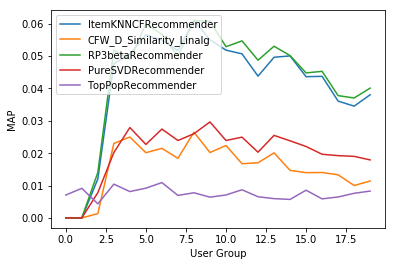

In [19]:
# Compare different recommenders
recommendersToCompare = [itemKNN, CFW_weithing, p3beta_rec]

if eval:
    from RecLib.Evaluate import *
    compare(URM_train, URM_test, recommendersToCompare)

In [ ]:
# Predict
final_Rec = hybridrecommender

if not eval:
    output = []
    for user_id in target_users:
        output.append((user_id, final_Rec.recommend(user_id, cutoff=10)))

In [ ]:
# Writedown results

if not eval:
    import csv
    with open('submission.csv', 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["user_id", "item_list"])
        for row in output:
          ranking = ''
          for val in row[1]:
            ranking = ranking + str(val) + ' '
          writer.writerow([row[0], ranking[:-1]])